In [4]:
!pip install folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import datetime
import statsmodels.formula.api as sm 

In [5]:
original = pd.read_excel('traffic_sample.xlsx')

In [6]:
# Converting the Latitude and Longitude Attributes to a Float
original["Latitude"] = original["Latitude"].astype(float)
original["Longitude"] = original["Longitude"].astype(float)

original = original[original["Gender"] != "U"]
original = original[(original["Year"] != 0) & (original["Year"] < 2020) & (original["Year"] > 1900)]


In [7]:
filtered_cols = ["Date Of Stop", "Time Of Stop", "SubAgency", 
                 "Description", "Location", "Latitude", "Longitude",
                 "Accident", "Belts", "Personal Injury", "Property Damage",
                 "Fatal", "Alcohol", "Work Zone", "VehicleType",
                 "Year", "Make", "Violation Type", "Contributed To Accident",
                 "Race", "Gender", "DL State"]

# Can break up the criteria above to make the dataframe more tidy
fil_df = original[filtered_cols]

In [9]:
# Make a sample (of size 5000) of the Traffic Violation dataset
sam = fil_df

In [10]:
def generate_map(loc = [39.1247, -77.1905], zoom = 10.5, tile = "openstreetmap"):
    res_map = folium.Map(location = loc, zoom_start = zoom, control_scale = True, tiles = tile)
    
    # Add the Tile (or Style) of the Map
    folium.TileLayer('openstreetmap').add_to(res_map)
    folium.TileLayer('Stamen Watercolor').add_to(res_map)
    folium.TileLayer('Stamen Toner').add_to(res_map)
    return res_map
    

In [11]:
# This Function returns the designated color assigned to a race.
def color_select(race):
    ethnicity = {'ASIAN': "#ed8134", # Orange
                 'BLACK': "#391cba", #Indigo
                 'HISPANIC': "#119992", #Teal 
                 'NATIVE AMERICAN': "#9412b8", # Violet 
                 'OTHER': "#127bb8", # Blue
                 'WHITE': "#e81c1c"} # Red
    
    return ethnicity[race]

# Map Exploring the Race and Gender 

In [30]:
# Creating an Empty Map
map_total = generate_map()

# other mapping code (e.g. lines, markers etc.)
asian_fg = folium.FeatureGroup(name = "Asian") 
black_fg = folium.FeatureGroup(name = "Black") 
his_fg = folium.FeatureGroup(name = "Hispanic") 
na_fg = folium.FeatureGroup(name = "Native American") 
other_fg = folium.FeatureGroup(name = "Other") 
white_fg = folium.FeatureGroup(name = "White") 

race = {'ASIAN': asian_fg, 
        'BLACK': black_fg, 
        'HISPANIC': his_fg, 
        'NATIVE AMERICAN': na_fg, 
        'OTHER': other_fg, 
        'WHITE': white_fg} 

legend_html = '''
    <style>
        .circle {
          height: 10px;
          width: 10px;
          background-color: orange;
          border-radius: 50%;
         }
         .square {
              height: 10px;
              width: 10px;
              background-color: #ed8134;
         }
         div {
             display: inline-block;
         }
         legend {
             font-size: 13px
         }
         .triangle {
            width: 0;
            height: 0;
            border-left: 7.5px solid transparent;
            border-right: 7.5px solid transparent;
            border-bottom: 15px solid #ed8134;
         }
    </style>
    
    <div style="position: fixed;
        left: 50px; width: 150px;
        border:2px solid black; z-index:9999; font-size:12px; background-color: white;"> 
        <legend><b>Legend:</b></legend>
        <b>Race: </b><br>
        Asian: <div class = circle style = "background-color: #ed8134"> </div> <br>
        White: <div class = circle style = "background-color: #e81c1c"> </div><br>
        Black: <div class = circle style = "background-color: #391cba"> </div><br>
        Hispanic: <div class = circle style = "background-color: #119992"> </div><br>
        Native American: <div class = circle style = "background-color: #9412b8"> </div><br>
        Other: <div class = circle style = "background-color: #127bb8"> </div>
        <hr>
        <b>Gender: </b><br>
        Male: <div class = triangle> </div> <br>
        Female: <div class = square> </div> <br>

    </div>

     '''
map_total.get_root().html.add_child(folium.Element(legend_html))

for ind, row in sam.iterrows():
    
    entry = (folium.RegularPolygonMarker(location = [row["Latitude"],row["Longitude"]], popup = row["Description"], 
                                        color= color_select(row["Race"]), fill = True, weight = 1, 
                                        number_of_sides = 3 if row["Gender"] == "M" else 6, 
                                        radius = 4, opactity = .4))
    entry.add_to(race[row["Race"]])

for r in race:
    race[r].add_to(map_total)
    
folium.LayerControl().add_to(map_total)


map_total

## Bar Graph Relating Gender, Race, and the number of Traffic Violation

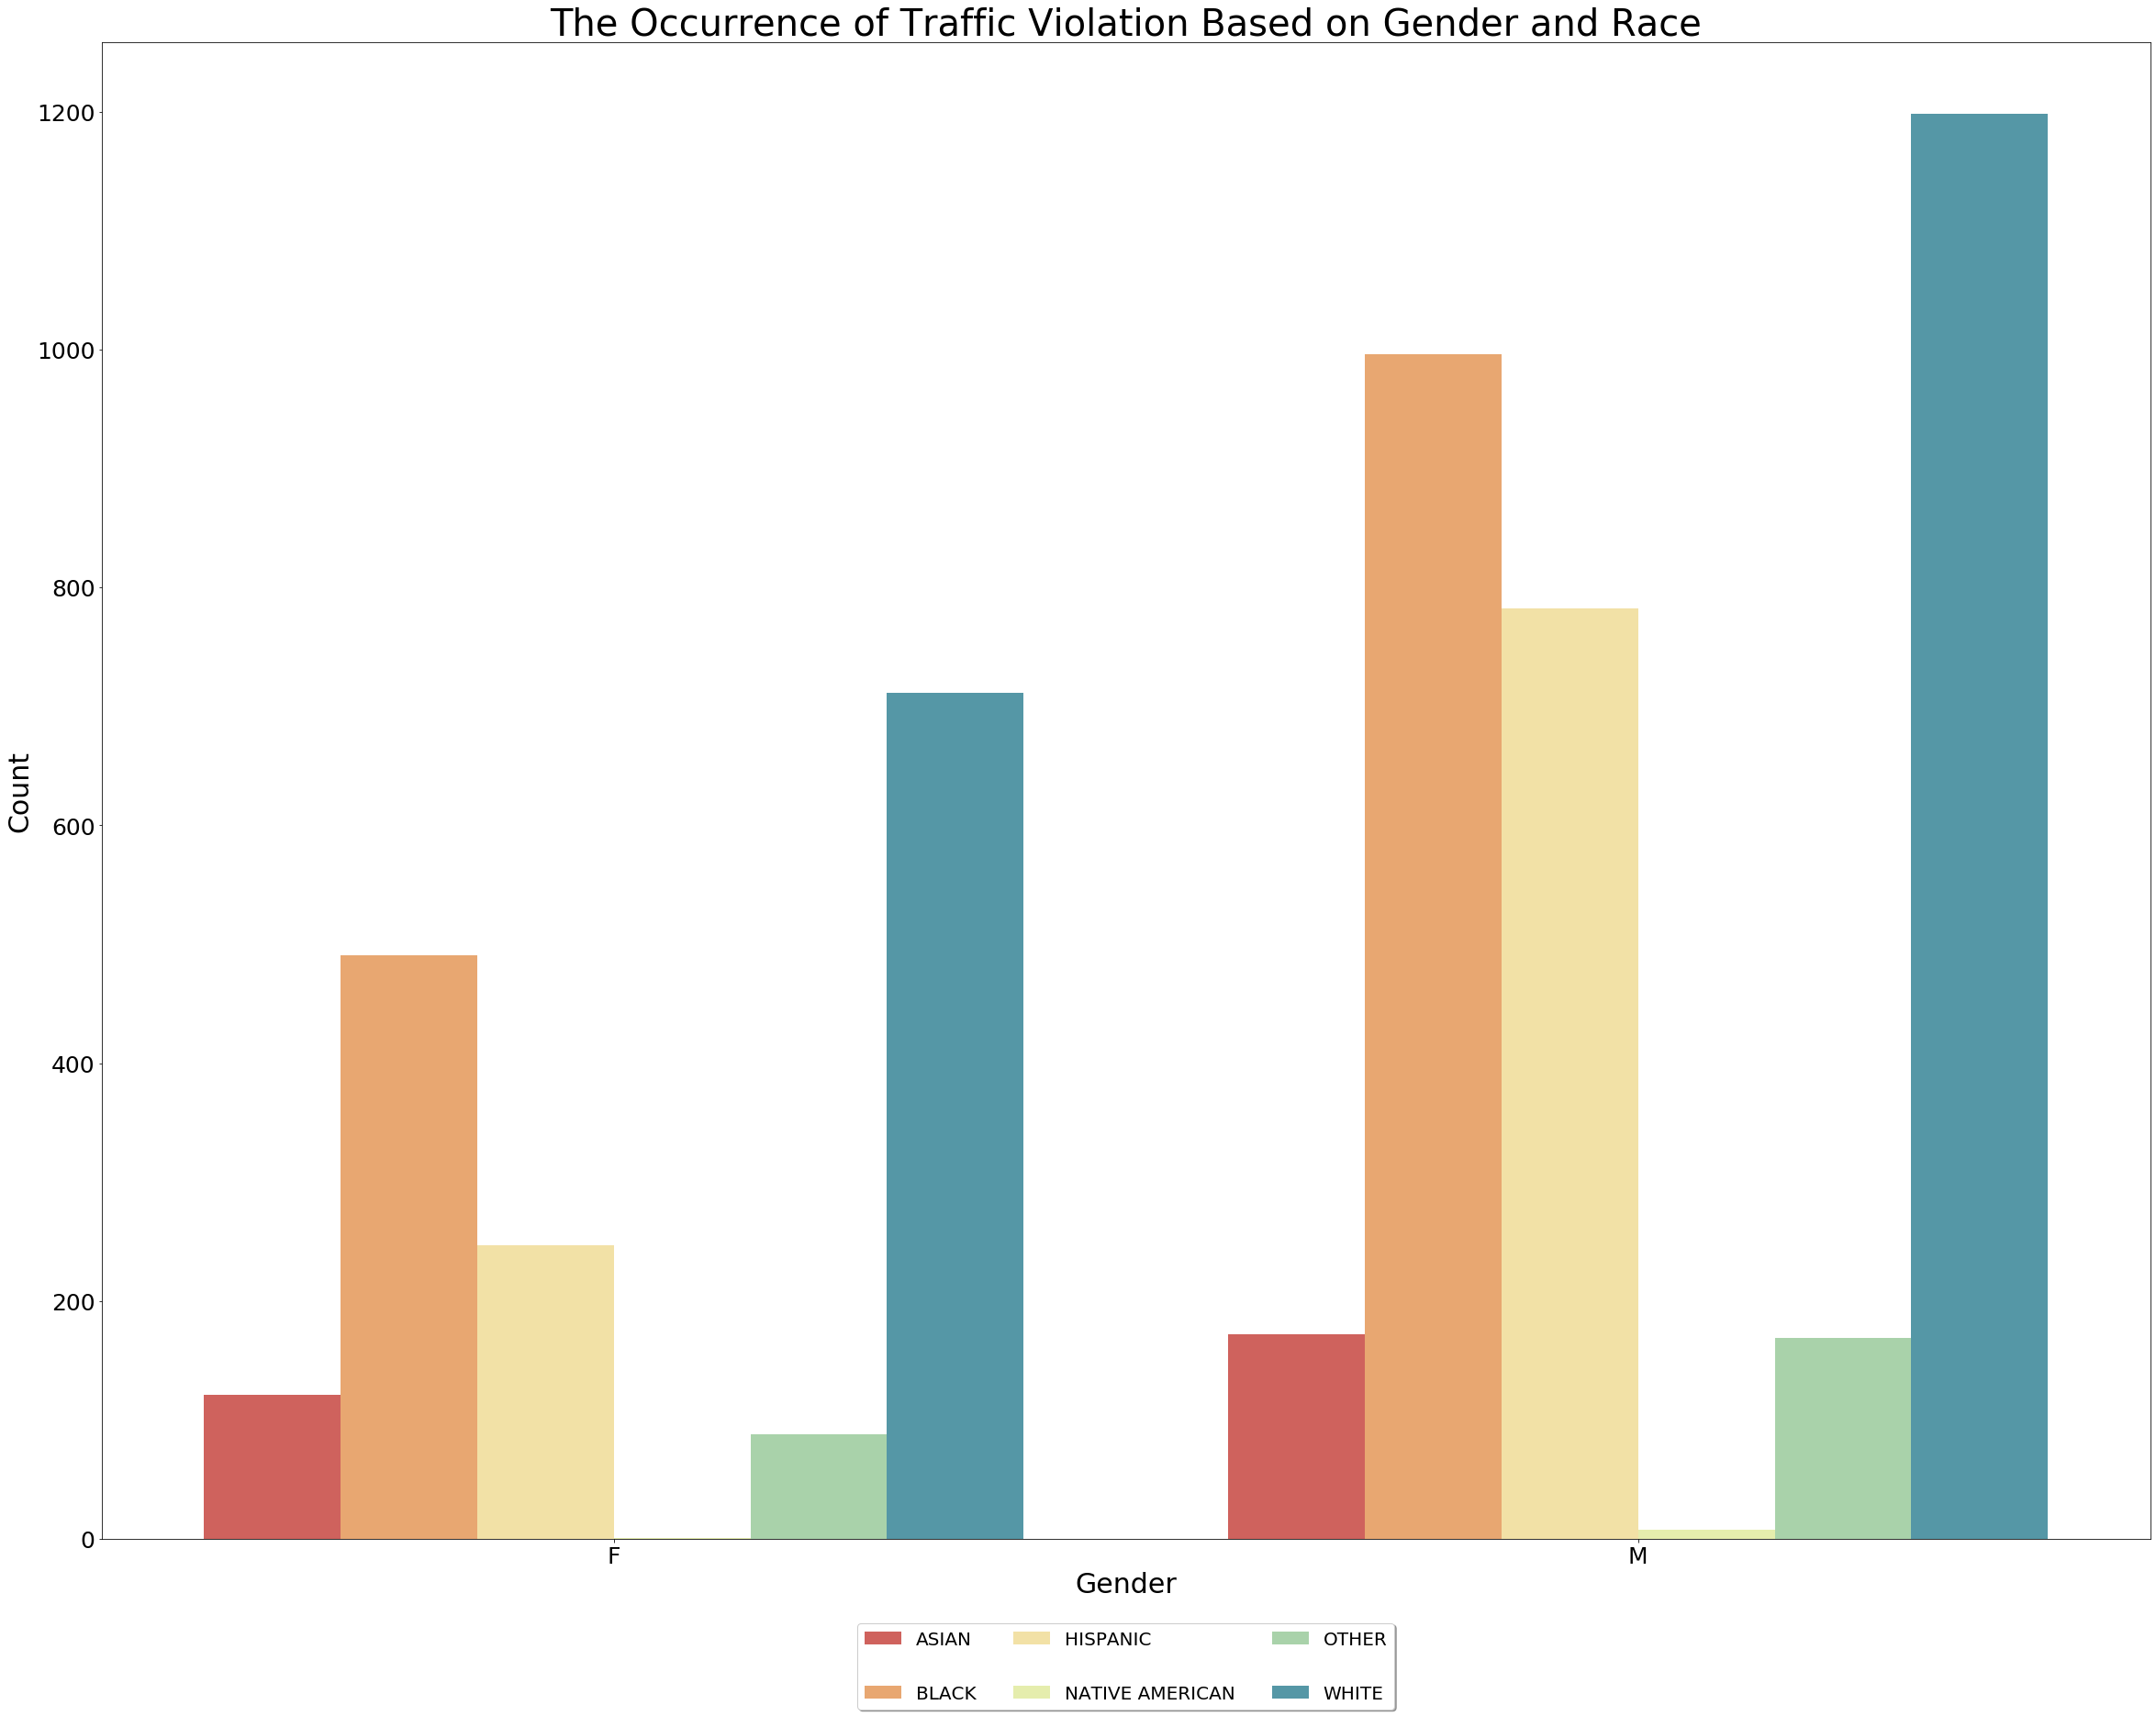

In [13]:
gr_df = sam.copy()
gr_df["count"] = 1

aggregation_functions = {'count': 'sum'}
nd = gr_df.groupby(['Gender', 'Race']).aggregate(aggregation_functions)

# Setting up the plot and dimension
fig, axs = plt.subplots() 
fig.set_figheight(30)
fig.set_figwidth(40)

b1 = sns.barplot(x="Gender", y ="count", hue="Race", palette = "Spectral", data=nd.reset_index(), ax = axs)
b1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, labelspacing=2, fontsize = 20)

b1.set_title("The Occurrence of Traffic Violation Based on Gender and Race", fontsize = 40)
b1.set_ylabel("Count", fontsize = 30)
b1.set_xlabel("Gender", fontsize = 30)
b1.tick_params(axis='both', labelsize=25)

plt.show()

# HeatMap Exploring the Occurrence based on Time (Hours)

In [14]:
sam["hour"] = [t.hour for t in sam["Time Of Stop"]]
cut = pd.cut(sam["hour"], bins = [0,2,4,6,8,10,12,14,16,18,20,22,24], 
             labels = [1,2,3,4,5,6,7,8,9,10,11,12], right = False)
sam["cut"] = cut

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
df_copy = sam.copy()
df_copy['count'] = 1
hr_map = generate_map()

hm_fg = []
hr = 0
for ind in range(12):
    temp_name = "Hours " + str(hr) + " to " + str(hr + 1)
    hm_fg.append(folium.FeatureGroup(name = temp_name, show= True if ind == 0 else False))
    hr += 2


# Group time together to have more during a specifc set of hours\
for index in range(12):    
    temp = df_copy[df_copy["cut"] == index + 1]
    HeatMap(data=temp[['Latitude', 'Longitude', 'count']]
                .groupby(['Latitude', 'Longitude', 'count'])
                .sum()
                .reset_index()
                .values.tolist(), 
                radius=8, max_zoom=13).add_to(hm_fg[index])
    
for fg in hm_fg:
    fg.add_to(hr_map)
        
    
folium.LayerControl().add_to(hr_map)

hr_map

## HeatMap Over Time

In [16]:
time_map = generate_map()
df_hour_list = []
for hour in df_copy["cut"].sort_values().unique():
    df_hour_list.append(df_copy.loc[df_copy.hour == hour, ['Latitude', 'Longitude', 'count']]
                        .groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())

HeatMapWithTime(df_hour_list, radius=8, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, max_opacity=0.8, use_local_extrema=True, auto_play=True).add_to(time_map)

folium.LayerControl().add_to(time_map)

time_map

# Total HeatMap

In [17]:
df_copy = sam.copy()
df_copy['count'] = 1
base_map = generate_map()

HeatMap(data=df_copy[['Latitude', 'Longitude', 'count']]
            .groupby(['Latitude', 'Longitude', 'count'])
            .sum()
            .reset_index()
            .values.tolist(), 
            radius=8, max_zoom=13).add_to(base_map)

folium.LayerControl().add_to(base_map)

base_map

# Exploring the Vehicle Type and Year

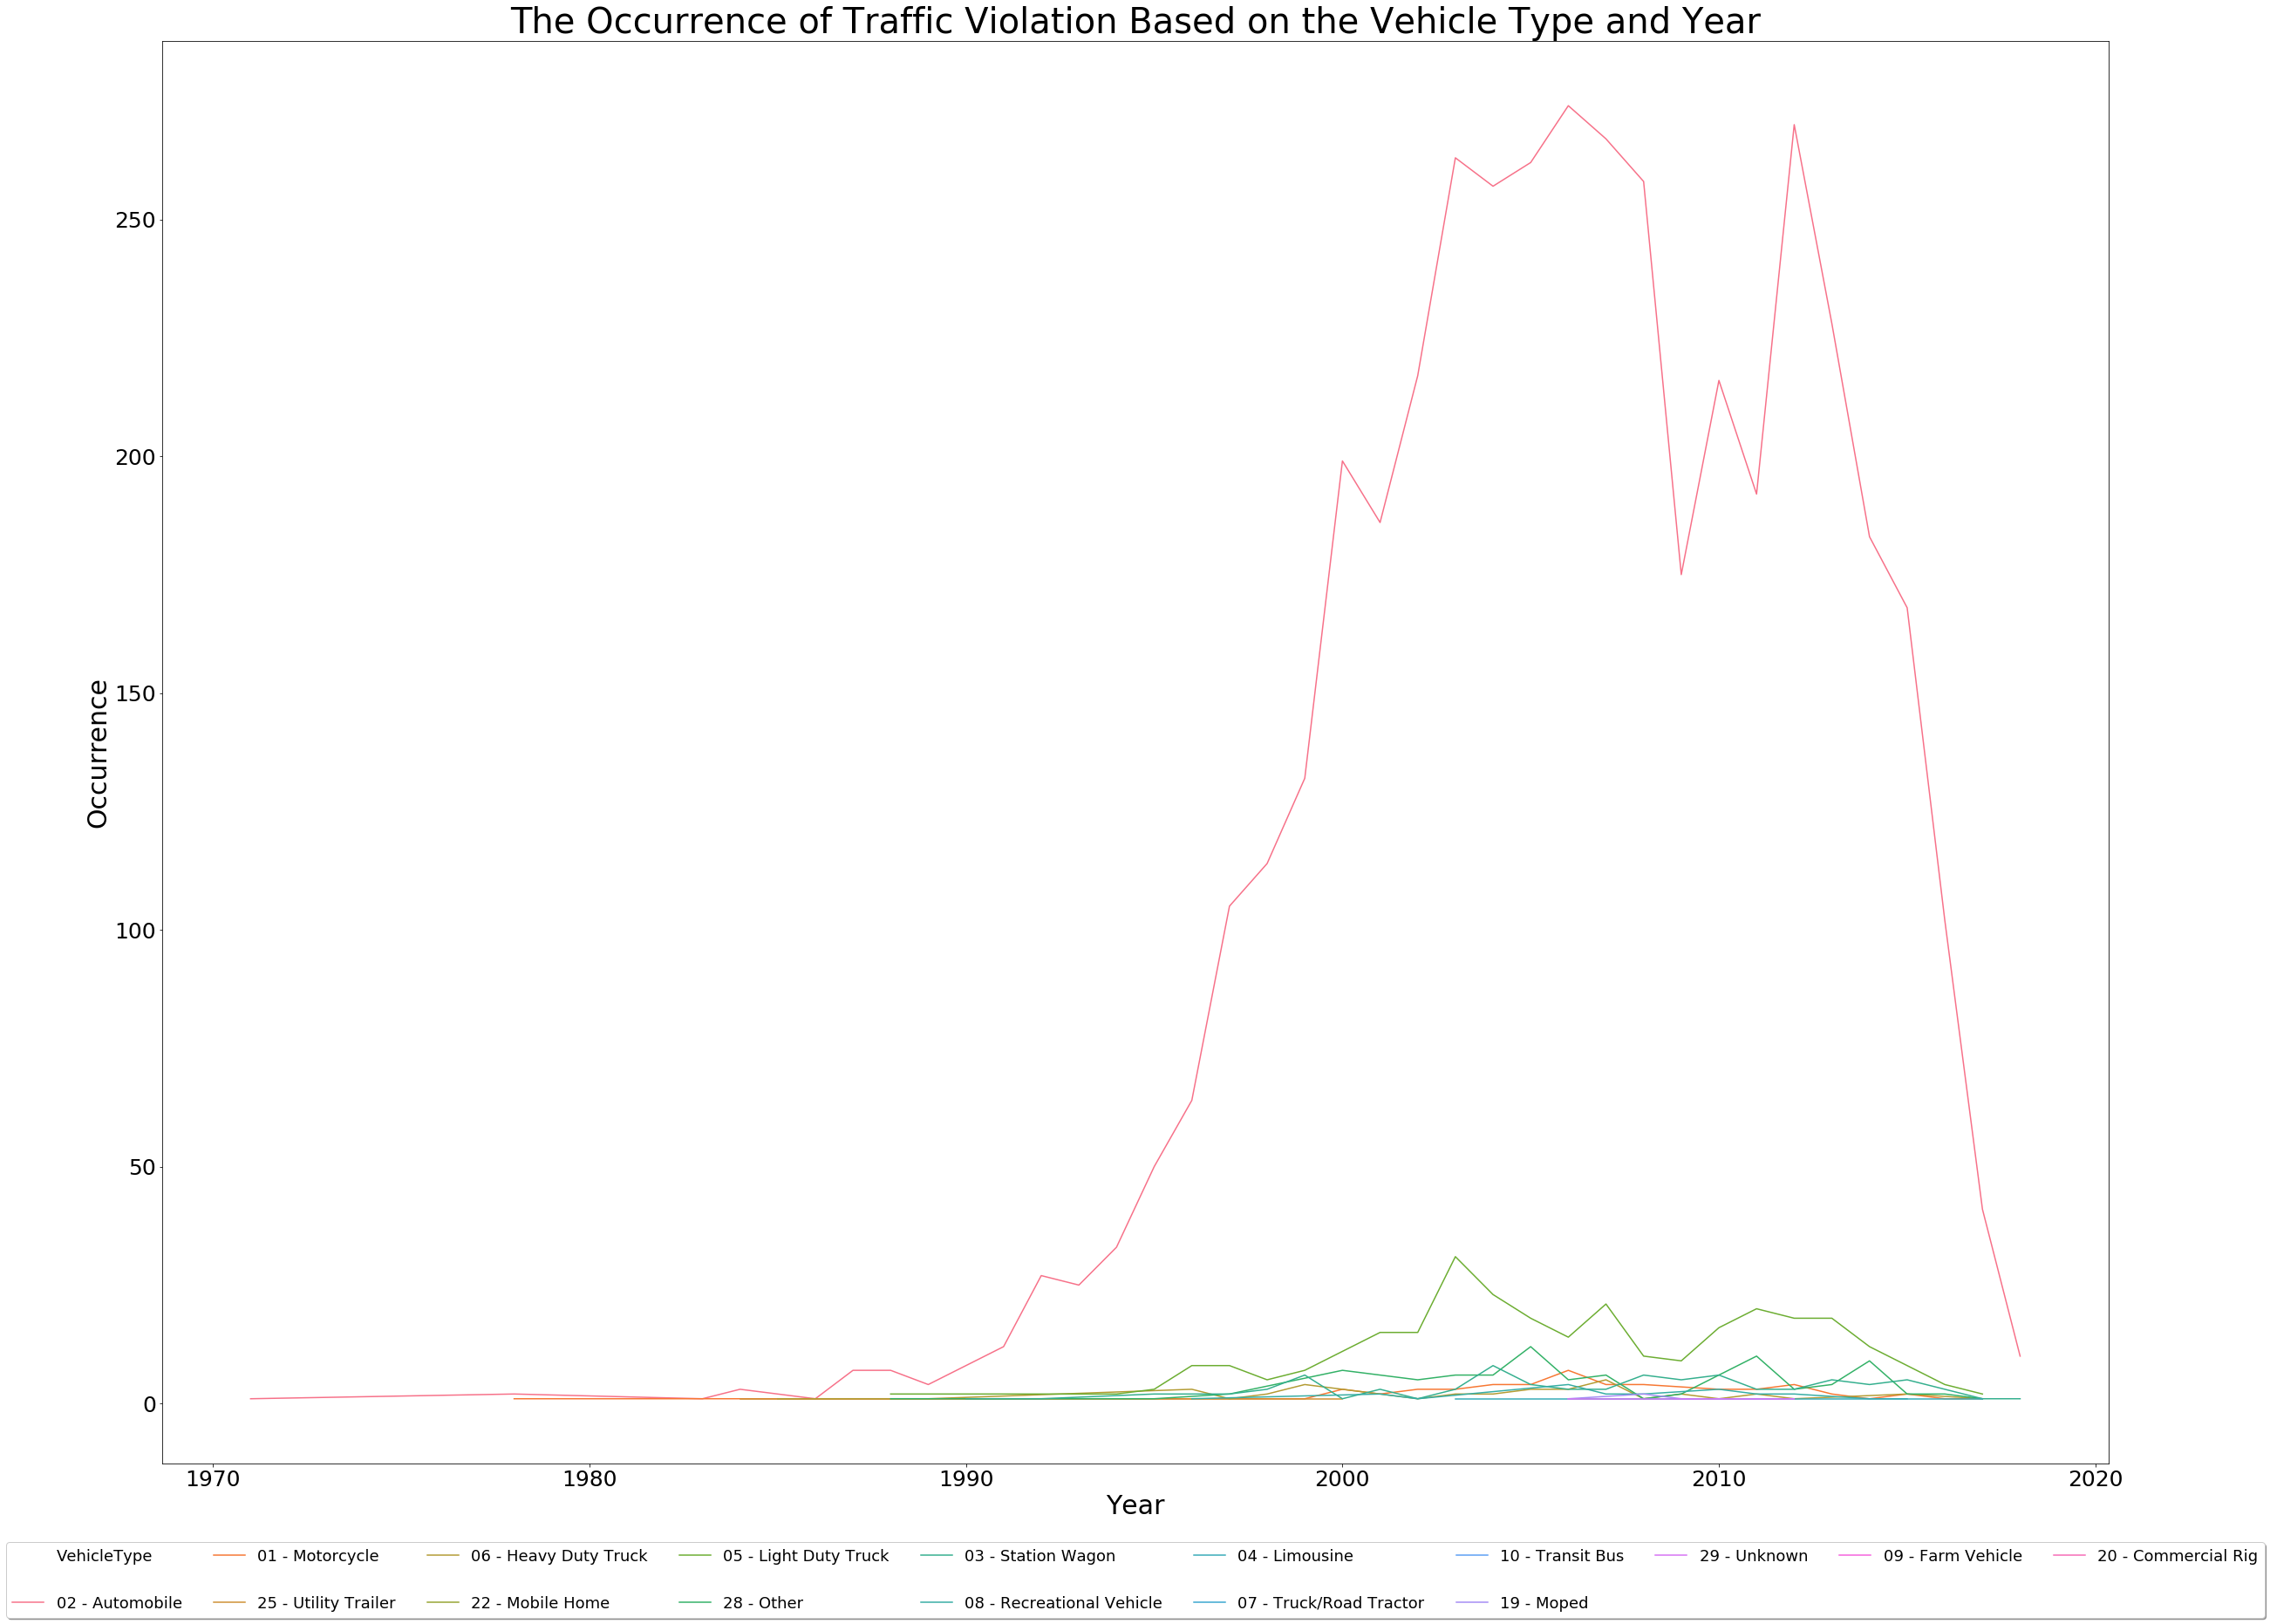

In [18]:
##### VehicleType, Year, Make
vy_df = sam.copy()
vy_df['count'] = 1
vy_df = vy_df.sort_values("Year")

aggregation_functions = {'count': 'sum'}
nd2 = vy_df.groupby(['Year', 'VehicleType']).aggregate(aggregation_functions)


# Setting up the plot and dimension
fig, axs = plt.subplots() 
fig.set_figheight(30)
fig.set_figwidth(40)

l = sns.lineplot(x = "Year", y = "count", hue = "VehicleType",data = nd2.reset_index(), ax = axs)
l.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10, labelspacing=2, fontsize = 18)

l.set_title("The Occurrence of Traffic Violation Based on the Vehicle Type and Year", fontsize = 40)
l.set_ylabel("Occurrence", fontsize = 30)
l.set_xlabel("Year", fontsize = 30)
l.tick_params(axis='both', labelsize=25)

plt.show()

# Can We Predict Where A Violation Might Occur?

In [19]:
district = np.unique(original["SubAgency"])
simp_district = {}

for dist in district:
    if dist[0] == "H":
        simp_district[dist] = 7
    else:
        simp_district[dist] = int(dist[0])


In [20]:
race_num = {'ASIAN': 0, 
            'BLACK': 1, 
            'HISPANIC': 2, 
            'NATIVE AMERICAN': 3, 
            'OTHER': 4, 
            'WHITE': 5} 
vt = {"Warning": 1,
      "Citation": 2,
      "ESERO": 3,
      "SERO": 4}

In [21]:
data_reg = sam.copy()

data_reg["district_num"] = [simp_district[d] for d in data_reg["SubAgency"]]
#data_reg = pd.get_dummies(data_reg, columns = ["Race"])
#data_reg["Race_NATIVE"] = data_reg["Race_NATIVE AMERICAN"]
data_reg["race_num"] = [race_num[r] for r in data_reg["Race"]]
data_reg["violation_type_num"] = [vt[v] for v in data_reg["Violation Type"]]
data_reg["gender_num"] = [0 if g == "M" else 1 for g in data_reg["Gender"]] 

data_reg["month"] = [m.month for m in sam["Date Of Stop"]]
data_reg["day"] = [d.day for d in sam["Date Of Stop"]]

data_reg

Date Of Stop Time Of Stop  \
0      2016-05-01     23:08:00   
1      2017-11-30     01:14:00   
2      2012-05-24     10:48:00   
3      2012-10-18     03:30:00   
4      2012-02-16     07:47:00   
...           ...          ...   
4995   2013-12-05     10:50:00   
4996   2015-09-27     18:15:00   
4997   2017-02-03     23:51:00   
4998   2015-07-02     23:18:00   
4999   2017-09-07     12:04:00   

                                            SubAgency  \
0                               4th district, Wheaton   
1                         3rd district, Silver Spring   
2                         3rd district, Silver Spring   
3                         3rd district, Silver Spring   
4     6th district, Gaithersburg / Montgomery Village   
...                                               ...   
4995                         5th district, Germantown   
4996                         5th district, Germantown   
4997                            4th district, Wheaton   
4998                          1st district, Rockville   
4999                         5th district, Germantown   

                                            Description  \
0     DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEFO...   
1     DRIVING VEHICLE IN EXCESS OF REASONABLE AND PR...   
2     DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...   
3     DRIVING TO DRIVE MOTOR VEHICLE ON HIGHWAY WITH...   
4     EXCEEDING MAXIMUM SPEED: 34 MPH IN A POSTED 25...   
...                                                 ...   
4995  DRIVER  WRITING,SENDING,READING A TEXT,ELECTRO...   
4996                OPERATOR NOT RESTRAINED BY SEATBELT   
4997  DRIVER TURNING VEHICLE WITHOUT GIVING APPROPRI...   
4998  FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAM...   
4999         DRIVER FAIL TO MAKE REQUIRED STOP AT SIGN.   

                                Location   Latitude  Longitude Accident Belts  \
0           GEORGIA AVE AT GLENALLAN AVE  39.063522 -77.055263       No    No   
1           RANDOLPH ROAD AT TAMARACK RD  39.067270 -76.984982       No    No   
2         WAYNE AVE / COLESVILLE RD, W/B  38.995165 -77.031199       No    No   
3           COLUMBIA PIKE AT LORRAIN AVE  38.998501 -77.026377       No    No   
4     GAME PRESERVE RD N/B (11400 BLOCK)  39.157287 -77.239419       No    No   
...                                  ...        ...        ...      ...   ...   
4995                    S/B 270 @ EXIT 6  39.120547 -77.198065       No    No   
4996       SHAKESPERRE RD/OBSERVATION DR  39.198568 -77.253565       No    No   
4997            GEORGIA AVE/ RANDOLPH RD  39.056312 -77.049788       No    No   
4998                   5405 TUCKERMAN LA  39.030070 -77.109265       No    No   
4999              MATENY RD/DAIRYMAID DR  39.151423 -77.268592       No    No   

     Personal Injury  ... Gender DL State hour cut district_num  race_num  \
0                 No  ...      M       MD   23  12            4         2   
1                 No  ...      M       MD    1   1            3         1   
2                 No  ...      F       MD   10   6            3         2   
3                 No  ...      M       WV    3   2            3         1   
4                 No  ...      F       MD    7   4            6         2   
...              ...  ...    ...      ...  ...  ..          ...       ...   
4995              No  ...      F       MD   10   6            5         5   
4996              No  ...      M       MD   18  10            5         5   
4997              No  ...      M       MD   23  12            4         2   
4998              No  ...      F       MD   23  12            1         1   
4999              No  ...      F       MD   12   7            5         2   

     violation_type_num gender_num month day  
0                     2          0     5   1  
1                     2          0    11  30  
2                     2          1     5  24  
3                     2          0    10  18  
4                     2          1     2  16  
...                 ..

In [22]:
#mlr = sm.ols(formula = 'lifeExp ~ year + continent_Asia + continent_Africa + continent_Europe + continent_Americas + continent_Oceania + year*continent_Asia + year*continent_Africa + year*continent_Europe + year*continent_Americas + year*continent_Oceania', data = data).fit()   
distlr = sm.ols(formula = 'district_num ~ hour + race_num + gender_num + violation_type_num', data = data_reg).fit()   
distlr.summary()


des = data_reg[["race_num", "gender_num", "violation_type_num"]].copy()
des["bias"] = 1
des = des[["bias","race_num", "gender_num", "violation_type_num"]]
dis = data_reg["district_num"]


X = np.asmatrix(des.to_numpy())
R = np.asmatrix(dis.to_numpy())
print (R)
A = np.linalg.inv(X.T * X) * X.T

W = (A * R.T).A1

W

[[4 3 3 ... 4 1 5]]


array([ 3.96055502, -0.06350476, -0.10527518, -0.11471471])

In [23]:
pred = W[0] + W[1]*des["race_num"] + W[2]*des["gender_num"] + W[3]*des["violation_type_num"]

pred

0       3.604116
1       3.667621
2       3.498841
3       3.667621
4       3.498841
          ...   
4995    3.423041
4996    3.528317
4997    3.718831
4998    3.562346
4999    3.613556
Length: 4984, dtype: float64

In [24]:
sp = data_reg.sample(n = 500)

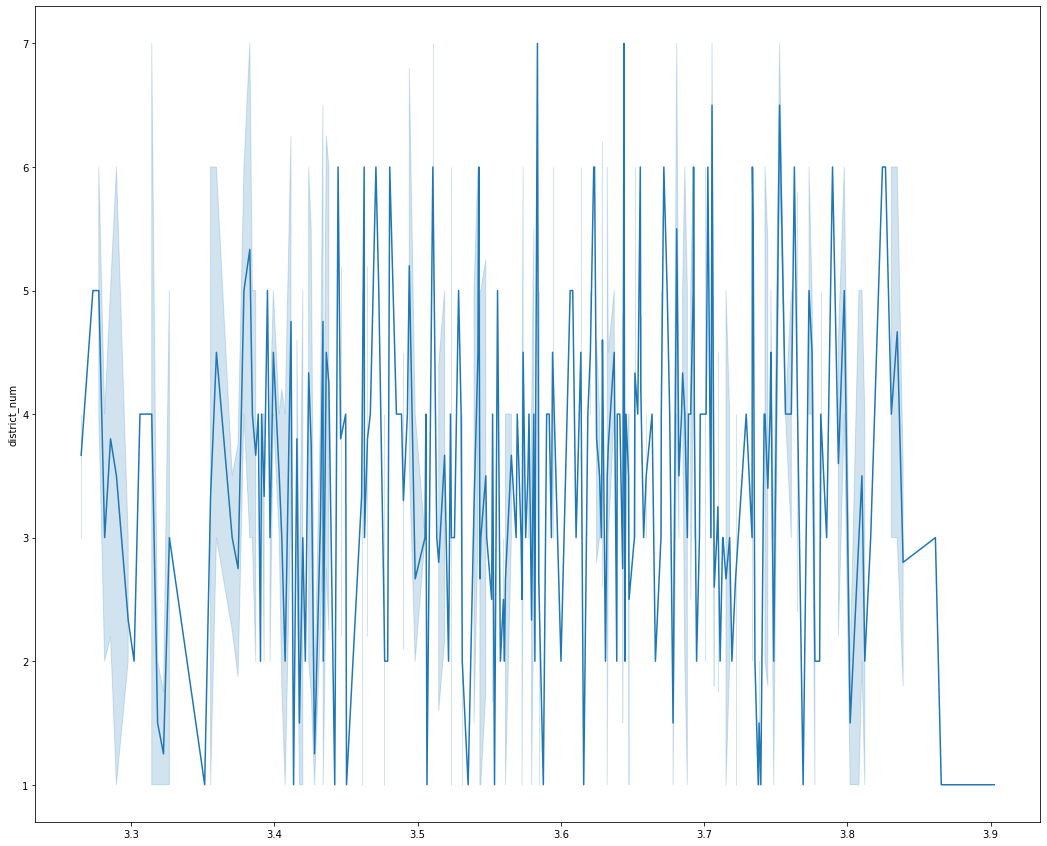

818     3.476435
4430    3.415727
1052    3.355450
2901    3.543501
3237    3.438043
          ...   
1526    3.824553
4380    3.382867
2441    3.584576
3311    3.506534
1608    3.721990
Length: 500, dtype: float64

In [25]:
# Setting up the plot and dimension
fig, axs = plt.subplots(nrows = 1)
fig.set_figheight(15)
fig.set_figwidth(18)

predict = distlr.predict({"hour": sp["hour"], 
                        "race_num": sp['race_num'], "gender_num": sp['gender_num'],
                        "violation_type_num": sp['violation_type_num']})

diff = sns.lineplot(x = predict, y =sp["district_num"], ax = axs)

plt.show()
predict